## Unsupervised Learning Capstone
>

In [46]:
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime as dt
from collections import Counter
import re
import spacy
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.corpus import brown, crubadan, timit

import sklearn
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# clustering models
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

In [26]:
# utility function
def text_cleaner(x):
    """Purpose:   Removing certain chars by using regular expressions
       Input:   a string
       Output:   cleaned string without special chars."""
    x = re.sub(r'--', ' ', x)
    x = re.sub(r'\*+', ' ', x)
    x = re.sub("[\[].*?[\]]", "", x)
    x = ' '.join(x.split())
    return x

In [27]:
def record_start_time(t = dt.now):
    """Purpose:   A system timer for start time
       Input:     the time
       Output:    print out the time."""
    print('start time {}'.format(t))
    return t

In [28]:
def record_end_time(starttime, t = dt.now):
    """Purpose:   A system timer for end time
       Input:   the time
       Output:  print out the time and the time passed."""
    print('end time {}'.format(t))
    print('Total time passed is {}'.format(t - starttime))
    return t

In [29]:
def word_frequencies(x, include_stop=True):
    """Generate word counts for a string."""
    words = []
    for token in x:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.text)
            
    return Counter(words)

In [30]:
def lemma_frequencies(text, include_stop=True):
    """Generate word lemma counts for a string"""
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
    
    return Counter(lemmas)

In [31]:
def bag_of_words(text, nsize, include_stop):
    """Generate list of words contained in a string."""
    container = lemma_frequencies(text, include_stop).most_common(nsize)
    return [item[0] for item in container]  

In [32]:
def bow_of_features(sentences, common_words, type_words):
    df = pd.DataFrame(columns=(['count'] + common_words + type_words))
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, 'count'] = 0
    df.loc[:, common_words] = 0
    df.loc[:, type_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        df.loc[i, 'count'] = len(sentence)
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
    
        for word in words:
            df.loc[i, word] += 1
        
        # type
        types = []
        for token in sentence:
            token_doc = nlp(token.text)
            for a_token in token_doc:
                holder = a_token.pos_
                if holder in type_words:
                    types.append(holder)
    
        for type in types:
            df.loc[i, type] += 1
        
        if i % 1000 == 0:
            print('Processing row {}'.format(i))
    
    print('All Done')
    return df

In [33]:
def stat_words_per_sentence(sentences, df):
    words = []
    for ss in sentences[0]:
        words.append(len(ss)) 
        
    df_local = pd.DataFrame(words, columns=['entity'])
    df['count'] = df_local.describe().loc['count', 'entity']
#    df['25perc'] = df_local.describe().loc['25%', 'entity']
#    df['50perc'] = df_local.describe().loc['50%', 'entity']
#    df['75perc'] = df_local.describe().loc['75%', 'entity']
    df['max'] = df_local.describe().loc['max', 'entity']

In [34]:
#print(brown.fileids())
print(gutenberg.fileids())

austen1 = gutenberg.raw('austen-' + 'emma' + '.txt')
austen2 = gutenberg.raw('austen-' + 'persuasion' + '.txt')
bryant = gutenberg.raw('bryant-' + 'stories' + '.txt')
burgess = gutenberg.raw('burgess-busterbrown' + '.txt')
carroll = gutenberg.raw('carroll-alice' + '.txt')
chesterton = gutenberg.raw('chesterton-brown' + '.txt')
edgeworth = gutenberg.raw('edgeworth-parents' + '.txt')
melville = gutenberg.raw('melville-moby_dick' + '.txt')
milton = gutenberg.raw('milton-paradise' + '.txt')
shakespeare = gutenberg.raw('shakespeare-caesar' + '.txt')
whitman = gutenberg.raw('whitman-leaves' + '.txt')

print('DONE')

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
DONE


In [35]:
# cleanup dataset
# remove VOLUME, CHAPTER
austen1 = re.sub(r'CHAPTER [I]*[V]*[X]*', '', austen1)
austen1 = re.sub(r'VOLUME [I]*[V]*[X]*', '', austen1)
austen1 = text_cleaner(austen1)
                 
austen2 = re.sub(r'Chapter \d+', '', austen2)
austen2 = text_cleaner(austen2)
                 
bryant = text_cleaner(bryant)
                 
burgess = re.sub(r'[I]*[V]*[X]*\n', '', burgess)
burgess = text_cleaner(burgess)

#carroll = re.sub[r'CHAPTER [A-Z]*.', '', carroll]
carroll = text_cleaner(carroll)                
                 
chesterton = text_cleaner(chesterton)

edgeworth = text_cleaner(edgeworth)
                 
milton = text_cleaner(milton)

shakespeare = text_cleaner(shakespeare)

whitman = text_cleaner(whitman)

# only use 1/10
austen1 = austen1[:int(len(austen1)/10)]
austen2 = austen2[:int(len(austen2)/5)]
chesterton = chesterton[:int(len(chesterton)/5)]
edgeworth = edgeworth[:int(len(edgeworth)/10)]
milton = milton[:int(len(milton)/5)]
whitman = whitman[:int(len(whitman)/10)]

In [36]:
# feature engineer
nlp = spacy.load('en_core_web_sm')
austen1_doc = nlp(austen1)
print('finish austen1')
austen2_doc = nlp(austen2)
print('finish austen2')
bryant_doc = nlp(bryant)
print('finish bryant')
burgess_doc = nlp(burgess)
print('finish byrgess')
carroll_doc = nlp(carroll)
print('finish carroll')
chesterton_doc = nlp(chesterton)
print('finish chesterton')
edgeworth_doc = nlp(edgeworth)
print('finish edgeworth')
milton_doc = nlp(milton)
print('finish milton')
shakespeare_doc = nlp(shakespeare)
print('finish shakespeare')
whitman_doc = nlp(whitman)
print('finish whitman')
print('DONE')

finish austen1
finish austen2
finish bryant
finish byrgess
finish carroll
finish chesterton
finish edgeworth
finish milton
finish shakespeare
finish whitman
DONE


In [37]:
# group into sentences
austen1_sents = [[sent, 0] for sent in austen1_doc.sents]                       # austen1 ---  0
austen2_sents = [[sent, 1] for sent in austen2_doc.sents]                       # austen2 ---  1
bryant_sents = [[sent, 2] for sent in bryant_doc.sents]                         # bryant  ---  2
burgess_sents = [[sent, 3] for sent in burgess_doc.sents]                       # burgess ---  3
carroll_sents = [[sent, 4] for sent in carroll_doc.sents]                       # carroll ---  4
chesterton_sents = [[sent, 5] for sent in chesterton_doc.sents]                 # chesterton ---  5
edgeworth_sents = [[sent, 6] for sent in edgeworth_doc.sents]                   # edgeworth ---6
milton_sents = [[sent, 7] for sent in milton_doc.sents]                         # milton  ---  7    
shakespeare_sents = [[sent, 8] for sent in shakespeare_doc.sents]               # shakespeare --- 8
whitman_sents = [[sent, 9] for sent in whitman_doc.sents]                       # whitman ---  9

sentences = pd.DataFrame(austen1_sents +
                         austen2_sents +
                         bryant_sents +
                         burgess_sents +
                         carroll_sents +
                         chesterton_sents +
                         edgeworth_sents +
                         milton_sents +
                         shakespeare_sents +
                         whitman_sents)
sentences.head()

,0,1
0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",0
1,"(She, was, the, youngest, of, the, two, daught...",0
2,"(Her, mother, had, died, too, long, ago, for, ...",0
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",0
4,"(Between, _, them)",0


In [38]:
# constructing bag_of_words
austen1_common = bag_of_words(austen1_doc, 20, False)        
austen2_common = bag_of_words(austen2_doc, 20, False)
bryant_common = bag_of_words(bryant_doc, 20, False)
burgess_common = bag_of_words(burgess_doc, 20, False)
carroll_common = bag_of_words(carroll_doc, 20, False)
chesterton_common = bag_of_words(chesterton_doc, 20, False)
edgeworth_common = bag_of_words(edgeworth_doc, 20, False)
milton_common = bag_of_words(milton_doc, 20, False)
shakespeare_common = bag_of_words(shakespeare_doc, 20, False)
whitman_common = bag_of_words(whitman_doc, 20, False)

# common and unique words
words_common = [x for x in (set(austen1_common) - set(austen2_common) - set(bryant_common) - set(burgess_common) -
                            set(carroll_common) - set(chesterton_common) - set(edgeworth_common) - set(milton_common) -
                            set(shakespeare_common) - set(whitman_common))]

for y in (set(austen2_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(bryant_common) - set(austen1_common) - set(austen2_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(burgess_common) - set(austen1_common) - set(bryant_common) - set(austen2_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(carroll_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(austen2_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(chesterton_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(austen2_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(edgeworth_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(austen2_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(milton_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(austen2_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(shakespeare_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(austen2_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(whitman_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(austen2_common)):
    words_common.append(y)


In [39]:
# constructing Dataset
type_words = ['PROPN', 'ADJ', 'ADV', 'CCONJ', 'NOUN', 'VERB', 'DET', 'PUNCT', 'ADP']
features = bow_of_features(sentences, words_common, type_words)
# add words per sentence statistics
#stat_words_per_sentence(sentences, features)

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 10000
Processing row 11000
All Done


## Now start with clustering model

In [40]:
# start clustering models
Y = features['text_source']
X = features.drop(['text_source', 'text_sentence'], 1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.75, random_state=42)

Comparing k-means and mini batch k-means solutions: 
text_source    0    1    2    3    4    5    6    7    8    9
row_0                                                        
0             94   99  628  115  168  199  135   66  199  152
1             47   27  139   78  147   30   37   16  163   25
2             28   15  134   41  145   17   57    2   55   10
3             85   29  475   70  535  134  135   25  178   33
4              9    4   43   10   17    6    6   10  195   31
5             99   43  250  119   68   97   35  109  229   53
6             99   54  214  132  146   55   67   25  138   42
7              6    5   18    8   18    5    4    0  305    6
8            293  236  656  366  378  157  266   72  239  113
9             65   47  208   62   56   53   38  263  443  148


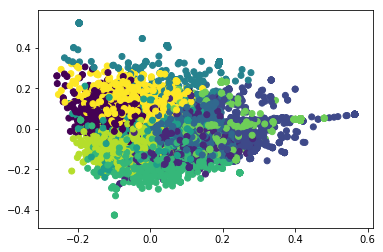

In [41]:
# KMeans cluster model
X_norm = normalize(X)
X_pca = PCA(10).fit_transform(X_norm)
Y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=Y_pred)

# Check the prediction against the data
print('Comparing k-means and mini batch k-means solutions: ')
print(pd.crosstab(Y_pred, Y))

In [47]:
confusion_matrix(Y, Y_pred)

array([[ 94,  47,  28,  85,   9,  99,  99,   6, 293,  65],
       [ 99,  27,  15,  29,   4,  43,  54,   5, 236,  47],
       [628, 139, 134, 475,  43, 250, 214,  18, 656, 208],
       [115,  78,  41,  70,  10, 119, 132,   8, 366,  62],
       [168, 147, 145, 535,  17,  68, 146,  18, 378,  56],
       [199,  30,  17, 134,   6,  97,  55,   5, 157,  53],
       [135,  37,  57, 135,   6,  35,  67,   4, 266,  38],
       [ 66,  16,   2,  25,  10, 109,  25,   0,  72, 263],
       [199, 163,  55, 178, 195, 229, 138, 305, 239, 443],
       [152,  25,  10,  33,  31,  53,  42,   6, 113, 148]], dtype=int64)

## Looks like the KMeans model don't do very well

In [48]:
# use miniBatch
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=300)
minibatchkmeans.fit(X_pca)
pred_mini = minibatchkmeans.predict(X_pca)

# Check the prediction against the previous solution
print('Comparing k-means and mini batch k-means solutions: ')
print(pd.crosstab(pred_mini, Y_pred))

Comparing k-means and mini batch k-means solutions: 
col_0     0    1    2     3    4    5    6    7     8    9
row_0                                                     
0        11    9    0     9    0  863    0    0    96  569
1         8  572    0     6    0   16   40    1    66    7
2       514    9    0    24    0  191    0    1   700   31
3         0    1    3     0    0    1    0  370     0    1
4         0   64  485   180    0    2    8    2     0    0
5        35   45   16  1354    5    3    0    0    13   93
6      1259    0    0     0    0    0    0    0   193  565
7         5    3    0    38    0   13  245    1  1697    0
8         4    0    0    87    0   13  679    0    11    4
9        19    6    0     1  326    0    0    0     0  113


In [50]:
print('Comparing mini batch k-means solutions and data: ')
print(pd.crosstab(Y, pred_mini))

Comparing mini batch k-means solutions and data: 
col_0          0    1    2    3    4    5    6    7    8    9
text_source                                                  
0            121   53  132    4   45   73   88  232   63   14
1             62   28   86    5   22   29  117  164   40    6
2            308  148  436   19  189  423  543  454  183   62
3            135   91  150    8   52   61  118  286   86   14
4             75  128  166   16  235  478  119  309  127   25
5            114   30  128    5   33  131  169   97   39    7
6             48   39   85    6   79  111  149  202   52    9
7            226   18   49    0    6   24  191   30   26   18
8            368  150  148  307   69  194  328  170  142  268
9            100   31   90    6   11   40  195   58   40   42


In [51]:
# use MeanShift model
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=300)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters : {}".format(n_clusters_))


Number of estimated clusters : 16


## model

In [52]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, Y_train)

print('Training set score : {}'.format(rfr.score(X_train, Y_train)))
cross_val_score(rfr, X_train, Y_train, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score : 0.8270241035005895


array([0.20005909, 0.14633641, 0.16303736, 0.20443608, 0.15959285])

In [53]:
# Now take it to test dataset
print('Testing set score : {}'.format(rfr.score(X_test, Y_test)))

Testing set score : 0.2143779224936786


In [54]:
print('Test set score : {}'.format(rfr.score(X_test, Y_test)))

Test set score : 0.2143779224936786
